# LSTNet Gluon Notebook End to End

## Download datasets

In [1]:
#!git clone https://github.com/laiguokun/multivariate-time-series-data

## Unzip files

In [2]:
#!gunzip multivariate-time-series-data/electricity/electricity.txt.gz
#!gunzip multivariate-time-series-data/exchange_rate/exchange_rate.txt.gz
#!gunzip multivariate-time-series-data/solar-energy/solar_AL.txt.gz
#!gunzip multivariate-time-series-data/traffic/traffic.txt.gz

## Fetch file names and paths

In [3]:
import glob
file_paths = glob.glob("multivariate-time-series-data/*/*.txt")
print(file_paths)

['multivariate-time-series-data/solar-energy/solar_AL.txt', 'multivariate-time-series-data/electricity/electricity.txt', 'multivariate-time-series-data/exchange_rate/exchange_rate.txt', 'multivariate-time-series-data/traffic/traffic.txt']


## Select time-series data

In [4]:
file_id = 1
file_path = file_paths[file_id]
text_file_name = file_paths[file_id].split('/')[-1]
out_path = 'output/model.param'
print(text_file_name, file_path, out_path)

('electricity.txt', 'multivariate-time-series-data/electricity/electricity.txt', 'output/model.param')


## LSTNet object

In [5]:
from __future__ import print_function

import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn, rnn


class LSTNet(gluon.Block):
    """
    LSTNet auto-regressive block
    """
    def __init__(self, ctx):
        super(LSTNet, self).__init__()
        self.ctx = ctx
        
    def build_model(self, num_series, conv_hid, gru_hid, skip_gru_hid, skip, ar_window):
        kernel_size = 6
        dropout_rate = 0.2
        self.skip = skip
        self.ar_window = ar_window
        with self.name_scope():
            self.conv = nn.Conv1D(conv_hid, kernel_size=kernel_size, layout='NCW', activation='relu')
            self.dropout = nn.Dropout(dropout_rate)
            self.gru = rnn.GRU(gru_hid, layout='TNC')
            self.skip_gru = rnn.GRU(skip_gru_hid, layout='TNC')
            self.fc = nn.Dense(num_series)
            self.ar_fc = nn.Dense(1)

    def forward(self, x):
        """
        :param nd.NDArray x: input data in NTC layout (N: batch-size, T: sequence len, C: channels)
        :return: output of LSTNet in NC layout
        :rtype nd.NDArray
        """
        # Convolution
        c = self.conv(x.transpose((0, 2, 1)))  # Transpose NTC to to NCT (a.k.a NCW) before convolution
        c = self.dropout(c)

        # GRU
        r = self.gru(c.transpose((2, 0, 1)))  # Transpose NCT to TNC before GRU
        r = r[-1]  # Only keep the last output
        r = self.dropout(r)  # Now in NC layout

        # Skip GRU
        # Slice off multiples of skip from convolution output
        skip_c = c[:, :, -(c.shape[2] // self.skip) * self.skip:]
        skip_c = skip_c.reshape((c.shape[0], c.shape[1], -1, self.skip))  # Reshape to NCT x skip
        skip_c = skip_c.transpose((2, 0, 3, 1))  # Transpose to T x N x skip x C
        skip_c = skip_c.reshape((skip_c.shape[0], -1, skip_c.shape[3]))  # Reshape to Tx (Nxskip) x C
        s = self.skip_gru(skip_c)
        s = s[-1]  # Only keep the last output (now in (Nxskip) x C layout)
        s = s.reshape((x.shape[0], -1))  # Now in N x (skipxC) layout

        # FC layer
        fc = self.fc(nd.concat(r, s))  # NC layout

        # Autoregressive highway
        ar_x = x[:, -self.ar_window:, :]  # NTC layout
        ar_x = ar_x.transpose((0, 2, 1))  # NCT layout
        ar_x = ar_x.reshape((-1, ar_x.shape[2]))  # (NC) x T layout
        ar = self.ar_fc(ar_x)
        ar = ar.reshape((x.shape[0], -1))  # NC layout

        # Add autoregressive and fc outputs
        res = fc + ar
        return res
    
    def compile_model(self, loss=None, lr = 0.001, clip_g = 10.):
        self.collect_params().initialize(init=mx.init.Xavier(factor_type="in", magnitude=2.34), ctx=self.ctx)
        self.trainer = gluon.Trainer(self.collect_params(),
                                     optimizer='adam',
                                     optimizer_params={'learning_rate': lr, 'clip_gradient': clip_g})
        self.loss = gluon.loss.L1Loss()
    
    def fit(self, ts_data, epochs = 100, batch_size = 128, out_path = 'model.params'):

        ctx = self.ctx
        
        train_data_loader = gluon.data.DataLoader(
            ts_data.train, batch_size=batch_size, shuffle=True, num_workers=16, last_batch='discard')

        scale = nd.array(ts_data.scale, ctx=ctx)

        loss = None
        print("Training Start")
        for e in range(epochs):
            epoch_loss = mx.nd.zeros((1,), ctx=ctx)
            num_iter = 0
            for data, label in train_data_loader:
                data = data.as_in_context(ctx)
                label = label.as_in_context(ctx)
                if loss is not None:
                    loss.wait_to_read()
                with autograd.record():
                    y_hat = self.forward(data)
                    loss = self.loss(y_hat * scale, label * scale)
                loss.backward()
                self.trainer.step(batch_size)
                epoch_loss = epoch_loss + loss.mean()
                num_iter += 1
            print("Epoch {:3d}: loss {:.4}".format(e, epoch_loss.asscalar() / num_iter))

        self.save_params(out_path)
        print("Training End")
        return 0


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## TimeSeriesData

In [6]:
from __future__ import print_function

from mxnet import gluon
import numpy as np


class TimeSeriesData(object):
    """
    Reads data from file and creates training and validation datasets
    """
    def __init__(self, file_path, window, horizon, train_ratio=0.8):
        """
        :param str file_path: path to the data file (e.g. electricity.txt)
        """
        # with open(file_path) as f:
        data = np.loadtxt(file_path, delimiter=',', dtype=np.float32)
        data = self._normalize(data)
        train_data_len = int(len(data) * train_ratio)
        self.num_series = data.shape[1]
        if train_ratio > 0.0:
            self.train = TimeSeriesDataset(data[:train_data_len], window=window, horizon=horizon)
        if train_ratio < 1.0:
            self.val = TimeSeriesDataset(data[train_data_len:], window=window, horizon=horizon)

    def _normalize(self, data):
        """ Normalizes data by maximum value per row (i.e. per time series) and saves the scaling factor

        :param np.ndarray data: input data to be normalized
        :return: normalized data
        :rtype np.ndarray
        """
        self.scale = np.max(data, axis=0)
        return data / self.scale


class TimeSeriesDataset(gluon.data.Dataset):
    """
    Dataset that splits the data into a dense overlapping windows
    """
    def __init__(self, data, window, horizon, transform=None):
        """
        :param np.ndarray data: time-series data in TC layout (T: sequence len, C: channels)
        :param int window: context window size
        :param int horizon: prediction horizon
        :param function transform: data transformation function: fn(data, label)
        """
        super(TimeSeriesDataset, self).__init__()
        self._data = data
        self._window = window
        self._horizon = horizon
        self._transform = transform

    def __getitem__(self, idx):
        """
        :param int idx: index of the item
        :return: single item in 'TC' layout
        :rtype np.ndarray
        """
        assert idx < len(self)
        data = self._data[idx:idx + self._window]
        label = self._data[idx + self._window + self._horizon - 1]
        if self._transform is not None:
            return self._transform(data, label)
        return data, label

    def __len__(self):
        """
        :return: length of the dataset
        :rtype int
        """
        return len(self._data) - self._window - self._horizon

## Make a time series object from a text file

In [7]:
ts_data = TimeSeriesData(file_path, window=24*7, horizon=24)

# Training the model

In [8]:
ctx = mx.gpu(0)
model = LSTNet(ctx)
model.build_model(num_series=ts_data.num_series,
                  conv_hid=100,
                  gru_hid=100,
                  skip_gru_hid=5,
                  skip=24,
                  ar_window=24)
model.compile_model()
model.fit(ts_data, epochs = 3, batch_size = 128, out_path = out_path)

Training Start
Epoch   0: loss 972.2
Epoch   1: loss 425.4
Epoch   2: loss 357.7
Training End


0

# Run inference using validation data

In [9]:
val_data_loader = gluon.data.DataLoader(ts_data.val, batch_size=2, shuffle=False, last_batch='discard')

In [10]:
import mxnet as mx
for data, label in val_data_loader:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    break

In [11]:
preds = model(data)

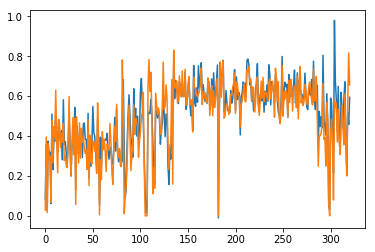

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(preds.asnumpy()[0], label = 'prediction')
line2, = ax1.plot(label.asnumpy()[0], label = 'ground truth')
plt.show()